In [1]:
"""
notebook: 1.6.-leibold-data-modeling_randomForest.jpynb

author: Christian Leibold

created/updated at: 2025-12-04

intention: use pipline preprocess data to model withh over- and undersampling + random forest model to create a first baseline model. 

content:
---------
-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2023 as base for this notebook 
-> preprocessing with preprocessing_pipeline
-> pipline with over- and undersampling resampling + random forest model
-> RandomSearchCV + stratifedKFold to optimize hyperparamethers
-> save fitted model and pipeline to local storage
-> PCA to check class seperability
-> first SHAP analysis

"""

'\nnotebook: 1.5.-leibold-data-modeling_randomForest.jpynb\n\nauthor: Christian Leibold\n\ncreated/updated at: 2025-11-30\n\nintention: create preprocessing pipeline to prepare data from concat joblib. \n           use random forest model with smote to create a first baseline model. \n\ncontent:\n---------\n-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2024 as base for this notebook \n-> create a pipeline with most important preprocessing steps\n-> NEW: use GridSearchCV to optimize hyperparamethers\n-> create random forest model + smote resampling\n-> save model to local storage\n\n'

In [1]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

# pipeline compatibel classes
from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import RearrangeCatCols             # bundle veh classes together to higher-tier classes
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation
from road_accidents_pipeline import TrigonometricEncoder         # encoding for cyclic variables lice acc_month or acc_hour
from road_accidents_pipeline import SafeColumnSelector           # makes sure only to use existing columns in pipeline

# scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# encoder
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# model classifier
from sklearn.ensemble import RandomForestClassifier

# hyperparameter optimization
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time



In [5]:
# -------------------------------------------------------------------------------------------------
# read in joblib with concatenated data and define which data to keep
# -------------------------------------------------------------------------------------------------
df_ori = load(r'..\..\..\temp_data\1.2-leibold-data-preprocessing_concat.joblib')
df = df_ori.loc[df_ori['acc_year'].between(2019, 2023)]
#df = df.loc[(df['acc_year']==2024) | (df['acc_year']==2023)]
#df = df.sample(n=10000)
#df = df_ori

print("original shape:", df_ori.shape)
print("kept shape:", df.shape)
display(df.head(3))

original shape: (762666, 44)
kept shape: (612769, 44)


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,veh_id,loca_road_cat,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection
0,201900000001,2,2,2,2,0,1,0,<NA>,<NA>,...,138 306 524,1,3,10.0,1,2.0,1.0,1,70.0,0
1,201900000001,1,1,2,2,5,1,0,<NA>,<NA>,...,138 306 524,1,3,10.0,1,2.0,1.0,1,70.0,0
2,201900000001,1,1,1,1,0,1,0,<NA>,<NA>,...,138 306 525,1,3,10.0,1,2.0,1.0,1,70.0,0


In [9]:
# -------------------------------------------------------------------------------------------------
# create sample dataframe respecting ind_severity distribution and using rows from all years
# -------------------------------------------------------------------------------------------------
# Example proportion
prop = 0.7  

# Filter years 2019–2023 -> 2024 then shall be used to pretend to be "new" data
df_filtered = df_ori[df_ori['acc_year'].between(2019, 2023)]

# Compute target sample size
target_size = int(len(df_filtered) * prop)

# Step 1: Split by year
samples = []
n_years = df_filtered['acc_year'].nunique()

for year, df_year in df_filtered.groupby('acc_year'):
    # Equal share per year
    year_target_size = target_size // n_years

    # Step 2: Stratified sampling within year by ind_severity
    df_year_sample = (
        df_year
        .groupby('ind_severity', group_keys=False)
        .sample(
            n=None,  # let pandas compute based on frac
            frac=year_target_size / len(df_year),
            random_state=42
        )
    )
    samples.append(df_year_sample)

# Concatenate all year samples
df = pd.concat(samples)

print(df['acc_year'].value_counts())                     # equal counts per year
print(df['ind_severity'].value_counts(normalize=True))   # distribution preserved
print(df_ori['ind_severity'].value_counts(normalize=True))
print(df.shape)

acc_year
2019    85787
2021    85787
2023    85787
2020    85786
2022    85786
Name: count, dtype: int64
ind_severity
1    0.415032
2    0.406434
3    0.152956
4    0.025577
Name: proportion, dtype: float64
ind_severity
1    0.416165
2    0.406967
3    0.151538
4    0.025330
Name: proportion, dtype: float64
(428933, 44)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 612769 entries, 0 to 648246
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   acc_num                 612769 non-null  int64         
 1   ind_place               612769 non-null  int64         
 2   ind_cat                 612769 non-null  int64         
 3   ind_severity            612769 non-null  int64         
 4   ind_sex                 612769 non-null  int64         
 5   ind_trip                612769 non-null  int64         
 6   ind_secu1               612101 non-null  Int64         
 7   ind_secu2               371376 non-null  Int64         
 8   ind_location            334676 non-null  Int64         
 9   ind_action              364188 non-null  Int64         
 10  ind_year                612769 non-null  int64         
 11  ind_age                 612769 non-null  Int64         
 12  ind_age_group           612769 non-

In [7]:
# -------------------------------------------------------------------------------------------------
# data split
# -------------------------------------------------------------------------------------------------
# Separate features and target
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (490215, 43)
y_train shape: (490215,)
X_test shape: (122554, 43)
y_test shape: (122554,)


In [8]:
# -------------------------------------------------------------------------------------------------
# check missing values
# -------------------------------------------------------------------------------------------------
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                    539
ind_secu2                 192852
ind_location              222442
ind_action                198855
acc_ambient_lightning          8
acc_atmosphere                29
acc_intersection              27
acc_collision_type          3004
veh_impact                   210
veh_maneuver               26855
loca_road_lanes            10793
loca_road_view               309
loca_road_surface_cond       439
loca_max_speed             12693
dtype: int64


In [9]:
# -------------------------------------------------------------------------------------------------
# define columns to be operated: read in columns from dictionary for later use in pipeline
# -------------------------------------------------------------------------------------------------
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict
missing_cat_cols = [col for col in cat_cols if col in X_train.columns and X_train[col].isna().any()] # Restrict to those with missing values

ohe_cols = cols_dict['oneHot_encoder']
valid_ohe_cols = [col for col in ohe_cols if col in X_train.columns] # Restrict to existing columns


⚠️ Missing columns (ignored): ['loca_road_count']


In [10]:
# -------------------------------------------------------------------------------------------------
# Full preprocessing pipeline
# -------------------------------------------------------------------------------------------------
# steps:
# --------------------------------------------------------
# - RemoveIrrelevantCols: Drops columns not useful for prediction.
# - ConditionalMultiQuantImputer: Imputes missing numeric values based on road category.
# - ConditionalCatImputer: Fills missing categorical values conditionally on target distribution.
# - AggrLocaSplit: Aggregates location features for intersections.
# - RemoveIdCols: Removes identifier columns used in aggregation.
# - RearrangeCatCols: merge some classes in veh categorical columns to reduce cardinatliy.
# - ColumnTransformer: Applies cyclic encoding, one-hot, CatBoost encoding, and scaling to features.


# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'), columns=["acc_municipality"])
cyclical_transformer = TrigonometricEncoder({"acc_hour": 24, "acc_month": 12})

# instantiate Scaler
scaler = MinMaxScaler()

# load unfitted pipeline
preprocessing_pipeline = load("../../models/preprocessing_pipeline.pkl")

# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# Access the fitted aggregation step
aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error)
y_train_piped = aggr_step.transform_y(X_train, y_train)
y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


[Pipeline] ....... (step 1 of 7) Processing remove_cols, total=   0.1s
[Pipeline] ...... (step 2 of 7) Processing impute_quant, total= 1.3min
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.
[Pipeline] ........ (step 3 of 7) Processing impute_cat, total= 1.7min
ℹ️ AggrLocaSplit -> Aggregated from 490215 rows to 467558 groups.
[Pipeline] ......... (step 4 of 7) Processing aggregate, total=  14.3s
[Pipeline] .... (step 5 of 7) Processing remove_id_cols, total=   0.1s
[Pipeline]  (step 6 of 7) Processing rearrange_categories, total=   0.3s
[Pipeline] ...... (step 7 of 7) Processing encode_scale, total=   2.2s
ℹ️ AggrLocaSplit -> Aggregated from 490215 rows to 467558 groups.
ℹ️ AggrLocaSplit -> Aggregated from 122554 rows to 121165 groups.
⏱️ Preprocessing Pipeline fit completed in 6.50 minutes


In [13]:
# --------------------------------------------------------------------------------------------------
# Random Forest Standard + class_weight="balanced"
# --------------------------------------------------------------------------------------------------
# Initialize RandomForest model
best_rf = RandomForestClassifier(
    n_estimators=500,        # number of trees
    max_depth=30,          # let trees expand fully
    min_samples_split=2,     # default split criteria
    min_samples_leaf=1,      # default leaf size
    random_state=42,         # reproducibility
    n_jobs=-1,                # use all cores for speed
    class_weight="balanced"
)

# Fit the model
best_rf.fit(X_train_piped, y_train_piped)

# Predict on test set
y_test_pred_best = best_rf.predict(X_test_piped)
y_train_pred_best = best_rf.predict(X_train_piped)



In [11]:
# --------------------------------------------------------------------------------------------------
# modelling with pipeline
# --------------------------------------------------------------------------------------------------
# Start timer
start_time = time.time()


# build pipeline with SMOTEEN and RandomForestClassifier
model_pipeline = ImbPipeline([
                    ('under', RandomUnderSampler(random_state=42)),
                    ('over', RandomOverSampler(random_state=42)),    
                    ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
                ])

# Define parameter distributions
param_dist = {
    "clf__max_depth": [10, 15],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": ["balanced"]
}

# define StratifiedKFold
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)           

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,         
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# fit the search object 
search.fit(X_train_piped, y_train_piped)

# print best parameters and scores
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)

# access the best pipeline including SMOTEEN + RandomForest and take only the model step
best_rf = search.best_estimator_.named_steps["clf"]
        
# Predict on test and train set
y_test_pred_best = best_rf.predict(X_test_piped)
y_train_pred_best = best_rf.predict(X_train_piped)

y_test_proba = best_rf.predict_proba(X_test_piped)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ model fitting completed in {elapsed_minutes:.2f} minutes")

# Best parameters: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 20, 'clf__class_weight': 'balanced'}
# Best CV score: 0.4915361608861577
# model fitting completed in 127.64 minutes

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters: {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 15, 'clf__class_weight': 'balanced'}
Best CV score: 0.4626251830920562
⏱️ model fitting completed in 0.74 minutes


✅ RandomForest Results
Accuracy train: 0.6018269391177138
Accuracy test: 0.5880411009780052

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.81      0.76     50318
           2       0.71      0.43      0.54     49222
           3       0.38      0.39      0.38     18525
           4       0.12      0.62      0.21      3100

    accuracy                           0.59    121165
   macro avg       0.48      0.56      0.47    121165
weighted avg       0.65      0.59      0.60    121165



Predicted,1,2,3,4
Actual,,,,
1,40795,4624,2304,2595
2,13583,21386,8877,5376
3,1896,3759,7150,5720
4,225,253,703,1919


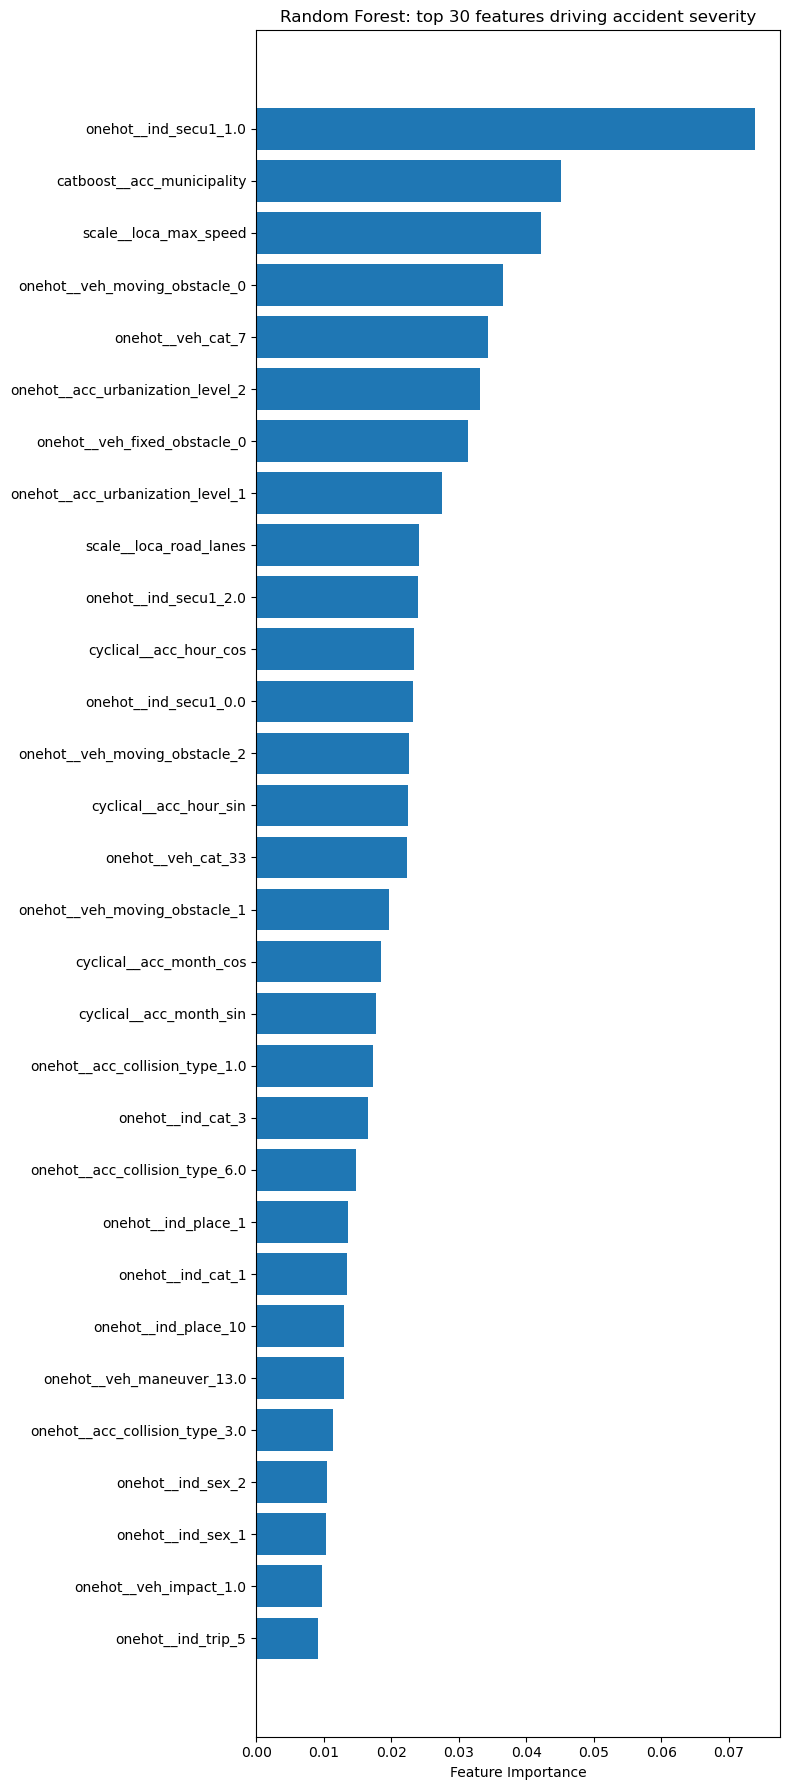

In [12]:
# --------------------------------------------------------------------------------------------------
# Evaluate performance
# --------------------------------------------------------------------------------------------------
print("✅ RandomForest Results")

# accuracy score to check if overfitted
print("Accuracy train:", accuracy_score(y_train_piped, y_train_pred_best))
print("Accuracy test:", accuracy_score(y_test_piped, y_test_pred_best))

# classifiction report
print("\nClassification Report:\n", classification_report(y_test_piped, y_test_pred_best))

# confustion matrix
display(pd.crosstab(y_test_piped, y_test_pred_best, rownames=["Actual"], colnames=["Predicted"]))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


# --------------------------------------------------------------------------------------------------
# Feature importance
# --------------------------------------------------------------------------------------------------
# pipline has np.array as output -> for feature_names a pd.DataFrame must be created to plot feature_importances_
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
#feature_names = preprocessing_pipeline.get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)

# Get feature importances from the trained RandomForest
importances = best_rf.feature_importances_
#feature_names = X_train_smote.columns

# Sort by importance
indices = np.argsort(importances)[::-1][:30]  # top 150

plt.figure(figsize=(8, 18))
plt.barh(range(len(indices)), importances[indices][::-1], align="center", height=0.8)
plt.yticks(range(len(indices)), feature_names[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest: top 30 features driving accident severity")
plt.tight_layout()
plt.show()

In [13]:
# --------------------------------------------------------------------------------------------------
# print out all Feature importances in table
# --------------------------------------------------------------------------------------------------
feature_importances = pd.Series(importances, index=X_train_piped_df.columns).sort_values(ascending=False)
fi_df = feature_importances.to_frame(name="importance")
fi_df = fi_df.sort_values("importance", ascending=False)

pd.set_option("display.max_rows", None)   # show all rows
#print(feature_importances)
display(fi_table)
pd.reset_option("display.max_rows")


NameError: name 'fi_table' is not defined

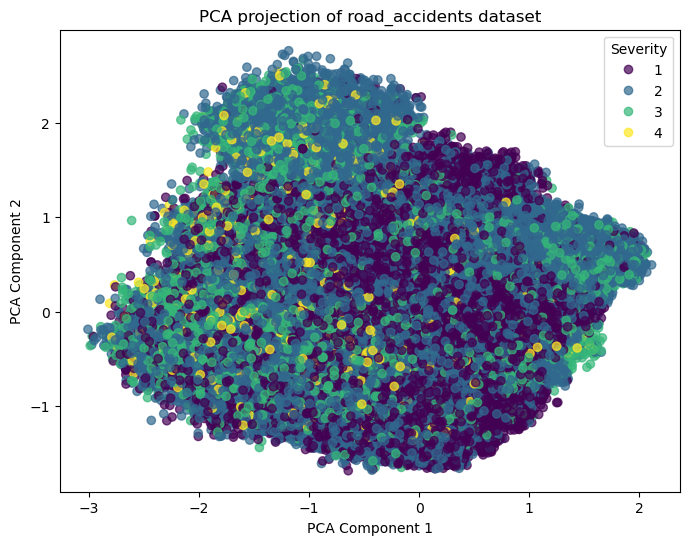

In [14]:
# PCA

pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test_piped)

# Plot with true labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test_piped, cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA projection of road_accidents dataset")
plt.legend(*scatter.legend_elements(), title="Severity")
plt.show()



In [33]:
# --------------------------------------------------------------------------------------------------
# check propabilities for each individual and class
# --------------------------------------------------------------------------------------------------
proba_df = pd.DataFrame(
    y_test_proba,
    columns=[f"class_{c}" for c in best_rf.classes_]
)

proba_df.head()


,class_1,class_2,class_3,class_4
0,0.813020,0.100797,0.038053,0.048131
1,0.355513,0.289563,0.248365,0.106560
2,0.008383,0.771361,0.192740,0.027517
3,0.017831,0.545638,0.316783,0.119749
4,0.889629,0.048518,0.033013,0.028840


In [19]:
# --------------------------------------------------------------------------------------------------
# safe fitted model
# --------------------------------------------------------------------------------------------------
dump(best_rf, "../../models/model_rf_over_under_2019_2023.joblib")

#dump(best_rf, "C:/Users/Christian/Documents/model_rf_over_under_2019_2023.joblib", compress=3)
#dump(best_rf, "C:/Users/Christian/Documents/model_rf_over_under_2019_2023_v2.joblib")


['../../models/model_rf_over_under_2019_2023.joblib']

In [20]:
# --------------------------------------------------------------------------------------------------
# safe fitted pipeline
# --------------------------------------------------------------------------------------------------
dump(preprocessing_pipeline, "../../models//pipeline_rf_over_under_2019_2023.pkl", compress=3)

#dump(preprocessing_pipeline, "C:/Users/Christian/Documents/pipeline_rf_over_under_2019_2023.pkl", compress=3)

['../../models//pipeline_rf_over_under_2019_2023.pkl']

In [21]:
# --------------------------------------------------------------------------------------------------
# stratified sample for SHAP values 
# --------------------------------------------------------------------------------------------------
# stratified sample for model explaining
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)

# transform sample the EXACT same way like the fitted model -> very important, otherwise SHAP values do not work
X_sub_clean = preprocessing_pipeline.transform(X_sub)



ℹ️ AggrLocaSplit -> Aggregated from 10000 rows to 9992 groups.


In [22]:
# OLD SHAP explainer
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sub_clean, approximate=True)


In [24]:
# feature names from pipeline
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()

# create dataframe to pass later to NEW SHAP explainer object
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)


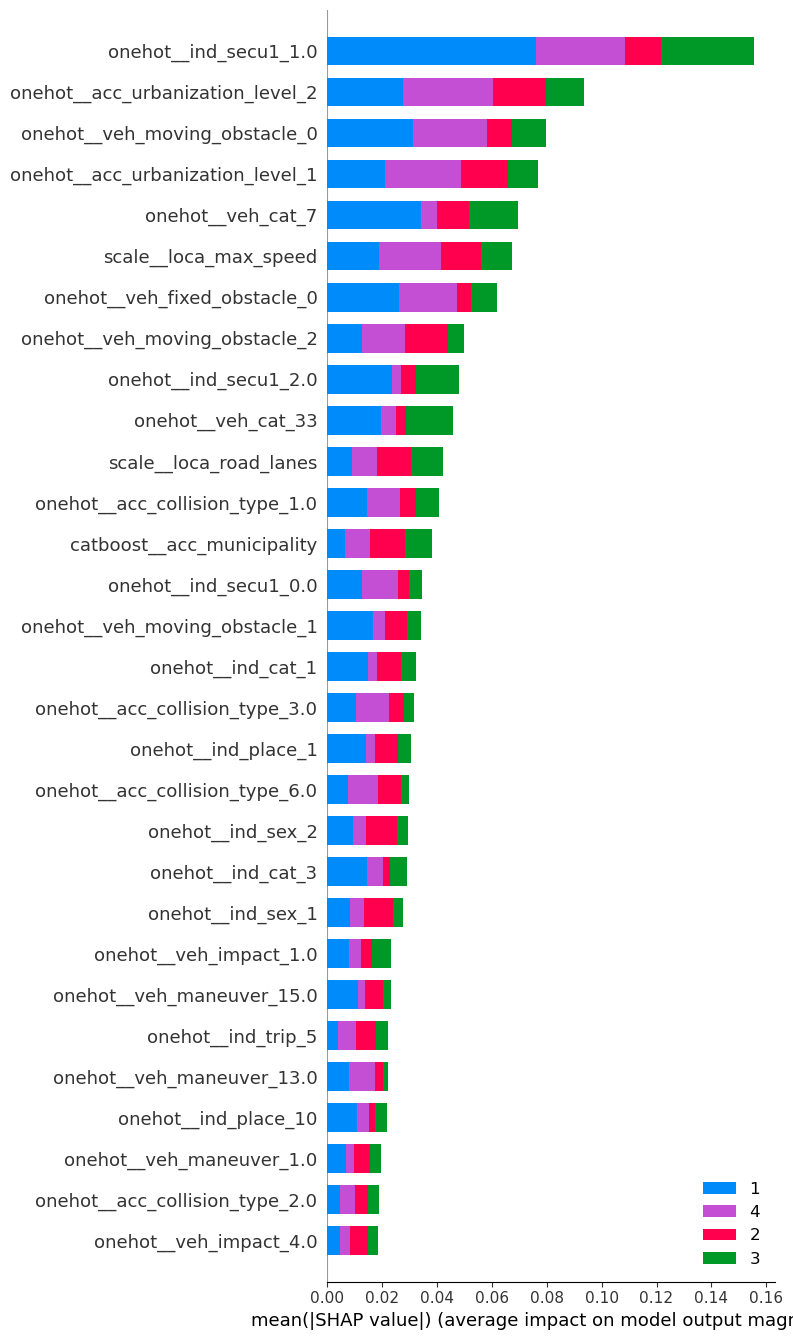

In [25]:
# OLD SHAP summary_plot over all classes
shap.summary_plot(shap_values, X_sub_df, plot_type="bar", class_names=best_rf.classes_ , title="Top 50 Features Random Forest Model", max_display=30)

